- Tem duas apis core e duas apis high level:
    - Apis core: NDArray e Symbol
    - Apis high-level: Gluon e Module ( e Keras)

In [1]:
!cat ~/.keras/keras.json

{
    "floatx": "float32",
    "epsilon": 1e-07,
    "backend": "mxnet",
    "image_data_format": "channels_first"
}


In [1]:

import keras
from keras.models import Sequential
from keras.layers import Dense
import mxnet as mx

Using MXNet backend


In [2]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import sklearn.preprocessing as preprocessing
from sklearn.model_selection import train_test_split
import sklearn

In [3]:
def plot_pie(y):
    from collections import Counter
    target_stats = Counter(y)
    labels = list(target_stats.keys())
    sizes = list(target_stats.values())
    explode = tuple([0.1] * len(target_stats))

    def make_autopct(values):
        def my_autopct(pct):
            total = sum(values)
            val = int(round(pct * total / 100.0))
            return '{p:.2f}%  ({v:d})'.format(p=pct, v=val)
        return my_autopct

    fig, ax = plt.subplots()
    ax.pie(sizes, explode=explode, labels=labels, shadow=True,
           autopct=make_autopct(sizes))
    ax.axis('equal')

In [4]:
df = pd.read_excel("BreastTissue.xls", sheet_name = "Data")
df.drop("Case #", axis = 1, inplace = True)
normalizer = lambda X: preprocessing.MinMaxScaler().fit_transform(X)
df[df.drop("Class",axis =1 ).columns] = normalizer(df.drop("Class",axis =1 ))



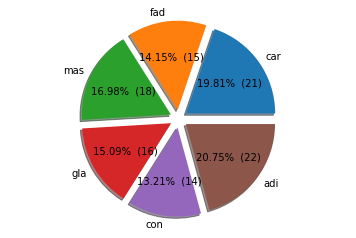

In [5]:
plot_pie(df["Class"])

In [6]:
def categorical_toNumerical(y):
    from sklearn import preprocessing
    enconder_output = preprocessing.LabelEncoder()
    a_str = y.astype('str')
    enconder_output.fit(a_str)
    categorical_to_numerical = enconder_output.transform(a_str)
    return(categorical_to_numerical)


df["Class"]  = categorical_toNumerical(df["Class"])

normalizer = lambda X: sklearn.preprocessing.MinMaxScaler().fit_transform(X)


df[df.drop("Class", axis = 1 ).columns] = normalizer(df
                                                   .drop("Class", axis = 1 ))

In [7]:
(X_train, X_test,
 y_train, y_test) = train_test_split(normalizer(df
                                      .drop("Class", axis = 1)), 
                                     df["Class"],
                                     test_size=0.33, shuffle = True)

# Keras implementation

In [8]:
model = Sequential()
model.add(Dense(31, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(6, activation='softmax'))
model.compile(optimizer = 'adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

history = model.fit(X_train,
                    keras.utils.to_categorical(y_train),
                    epochs=2100,
                    verbose = False, 
                    validation_data = (X_test, keras.utils.to_categorical(y_test)) )

/home/mvmaciel/anaconda3/envs/mx1/lib/python3.7/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.03125). Is this intended?
  force_init=force_init)


# MXNet implementation

In [9]:
from mxnet import autograd
from mxnet import gluon
import mxnet.ndarray as nd
import numpy as np


# for plotting purposes
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [10]:
import mxnet.gluon.nn as mx_nn
import mxnet.gluon as gluon
import mxnet.gluon.data as gdt


mx_net = mx_nn.Sequential()
mx_net.add(mx_nn.Dense(31, activation ='relu'),
          mx_nn.Dense(6))

mx_net.initialize()
#mx_loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()
mx_trainer = gluon.Trainer(mx_net.collect_params(),
                           'adam')

# Não consegui fazer one-hot encoding 

In [11]:
# train_data = (gdt.DataLoader(gdt.dataset.ArrayDataset(mx.nd.array(X_train),
#                                                      mx.nd.one_hot(mx.nd.array( y_train), len(y_train.unique()))),
#                              batch_size =  5))

# test_data = (gdt.DataLoader(gdt.dataset.ArrayDataset(mx.nd.array(X_test),
#                                                      mx.nd.one_hot(mx.nd.array( y_test), len(y_test.unique()))), 
#                             batch_size =  5))

In [12]:
train_data = (gdt.DataLoader(gdt.dataset.ArrayDataset(mx.nd.array(X_train),
                                                      mx.nd.array( y_train)),
                             batch_size =  5))

test_data = (gdt.DataLoader(gdt.dataset.ArrayDataset(mx.nd.array(X_test),
                                                     mx.nd.array(y_test)), 
                            batch_size =  5))

In [13]:
def accuracy(data_iterator, net, ctx=mx.cpu()):
    acc = mx.metric.Accuracy()
    for (data, label) in data_iterator:
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        predictions = mx.nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1]

In classification, we often apply the softmax operator to the predicted outputs to obtain prediction probabilities, and then apply the cross entropy loss against the true labels. Running these two steps one-by-one, however, may need to numerical instabilities. The loss module provides a single operators with softmax and cross entropy fused to avoid such problem.

In [14]:
def train(net, trainer, train_data, validation_data, epochs, ctx=mx.cpu()):
    training_accuracies = []
    validation_accuracies = []
    losses = []
    softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
    for e in range(epochs):
        for (data, label) in train_data:
            data  = data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            with autograd.record():
                output = net(data)
                loss = softmax_cross_entropy(output, label)
                loss.backward()
            trainer.step(data.shape[0])
        train_accuracy = accuracy(train_data, net)
        training_accuracies.append(train_accuracy)
        losses.append(loss.asscalar())
        validation_accuracy = accuracy(validation_data, net)
        validation_accuracies.append(validation_accuracy)
       # print("Epoch#{} Time={:.2f} Training={:.4f} Validation={:.4f} Loss={}".format(e,  toc-tic, train_accuracy,
        #                                                                              validation_accuracy,loss.asscalar()))
    return training_accuracies, validation_accuracies, losses

In [15]:
(training_accuracies, 
 validation_accuracies,
 losses) = train(mx_net, mx_trainer,train_data,test_data, 2500)

In [16]:
def plot_accuracies(training_accuracies, validation_accuracies, losses):
    import matplotlib.ticker as ticker
    epochs = len(training_accuracies)
    plt.clf()
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    train_plot, = ax.plot(range(epochs), training_accuracies,marker = "o",  label="Training accuracy")
    validation_plot, = ax.plot(range(epochs), validation_accuracies,marker = "o", label="Validation accuracy")
    loss_plot, = ax.plot(range(epochs), losses,marker = "o", label="Loss")
    
    plt.legend(handles=[train_plot,validation_plot, loss_plot])
    plt.xticks(rotation='vertical')
#    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.4f'))
    plt.show()

In [17]:
list(map(lambda f: f(validation_accuracies), [np.mean, np.std]))

[0.6585257142857145, 0.052970977344356476]

<Figure size 432x288 with 0 Axes>

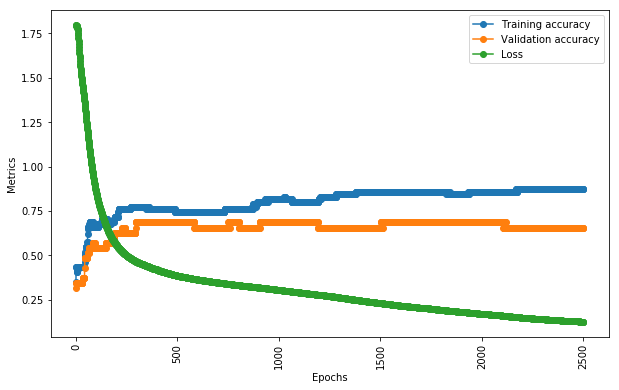

In [18]:
plot_accuracies(training_accuracies, validation_accuracies, losses)

### Esse loss é de treino e não sei por qual razão cai tanto.

# Plotting NN convergence

In [25]:
def nnconvergence(hist, title ="Rede neural - rodada única" ):
    f, ax = plt.subplots(figsize=(10, 6))
    ax.plot(hist.history['categorical_accuracy'], marker = "o", label = "acuracia(teste)")
    ax.plot(hist.history['val_categorical_accuracy'], marker = "o", label = "acuracia(val)")
    ax.plot(hist.history["loss"], marker = "o", label = "erro de treino")
    ax.set_title(title)
    ax.set_ylabel("Medidas")
    ax.set_xlabel("Iterações")
    ax.legend()
    


In [26]:
list(map(lambda f: f(history.history["val_categorical_accuracy"]), [np.mean, np.std]))

[0.6778503409072655, 0.10429626727894485]

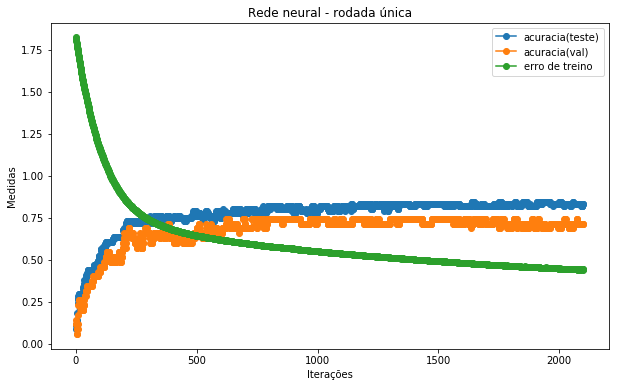

In [27]:
nnconvergence(history)

# Proximos passos
- 1. Implementar uma versão no Module api
- 2. Explicar o que é, quem ta por detras, qual o ecossistema de ferramentas
- 3. Explicar os pros e os contras 
- 4. Explicitar quais são as apis e os modulos da api python
- 5. Explicar melhor como funciona Gluon Api x Module api
- 6. Mostrar como seria a versão clojure e julia 
- 7. unificar os plots num grid